# Linear Model Simulation

このノートブックでは、`DegenerateDiffusionProcess` を用いて線形モデルのシミュレーションのみを行います。推定アルゴリズムには触れず、モデル定義と軌道の可視化に焦点を当てます。

## 1. SymPy によるモデル式の定義

記号変数を導入し、ドリフト $A$、拡散 $B$、観測関数 $H$ を構築します。
モデルは次の 1 次元 SDE で記述されます。

$$
\begin{aligned}
dX_t &= \bigl(-\theta_{20} X_t - \theta_{21} Y_t\bigr)\, dt + \theta_{10}\, dW_t,\\
dY_t &= \theta_{30} X_t\, dt.
\end{aligned}
$$

ここで $X_t, Y_t \in \mathbb{R}$、$W_t$ は 1 次元ブラウン運動です。
ドリフトや観測の形は
$$
A(x, y; \theta_2) = -\theta_{20} x - \theta_{21} y, \qquad
B(\theta_1) = [\theta_{10}], \qquad
H(x; \theta_3) = \theta_{30} x
$$
となります。

In [1]:
import sympy as sp

# State and observation symbols
x_sym, y_sym = sp.symbols("x y")
theta_10, theta_20, theta_21 = sp.symbols("theta_10 theta_20 theta_21")
theta_30 = sp.symbols("theta_30")

x = sp.Array([x_sym])
y = sp.Array([y_sym])
theta_1 = sp.Array([theta_10])
theta_2 = sp.Array([theta_20, theta_21])
theta_3 = sp.Array([theta_30])

# Drift, diffusion, and observation expressions
A_expr = sp.Array([-theta_20 * x_sym - theta_21 * y_sym])
B_expr = sp.Array([[theta_10]])
H_expr = sp.Array([theta_30 * x_sym])

theta_1, theta_2, theta_3, A_expr, B_expr, H_expr

([theta_10],
 [theta_20, theta_21],
 [theta_30],
 [-theta_20*x - theta_21*y],
 [[theta_10]],
 [theta_30*x])

## 2. DegenerateDiffusionProcess の生成

`DegenerateDiffusionProcess` に記号式を渡して JAX で利用できる関数へ変換します。

In [2]:
from degenerate_diffusion import DegenerateDiffusionProcess

linear_process = DegenerateDiffusionProcess(
    x=x,
    y=y,
    theta_1=theta_1,
    theta_2=theta_2,
    theta_3=theta_3,
    A=A_expr,
    B=B_expr,
    H=H_expr,
)
linear_process

DegenerateDiffusionProcess(x=[x], y=[y], theta_1=[theta_10], theta_2=[theta_20, theta_21], theta_3=[theta_30], A=SymbolicArtifact(expr=[-theta_20*x - theta_21*y], func=<function _lambdifygenerated at 0x129b544a0>), B=SymbolicArtifact(expr=[[theta_10]], func=<function _lambdifygenerated at 0x129b8cc20>), H=SymbolicArtifact(expr=[theta_30*x], func=<function _lambdifygenerated at 0x129b8d620>))

## 3. 真のパラメータとシミュレーション条件

`linearmodel.ipynb` と同じ真値と時間離散化条件を設定し、JAX 配列へ変換します。

In [6]:
import jax
import jax.numpy as jnp
import numpy as np

theta1_true = jnp.array([1.0], dtype=jnp.float32)
theta2_true = jnp.array([1.0, 1.0], dtype=jnp.float32)
theta3_true = jnp.array([1.0], dtype=jnp.float32)
true_theta = (theta1_true, theta2_true, theta3_true)

t_max = 100.0
burn_out = 50.0
h = 0.2
dt = 0.01
seed = 123

x0 = jnp.zeros((1,), dtype=jnp.float32)
y0 = jnp.zeros((1,), dtype=jnp.float32)

{"theta": true_theta, "t_max": t_max, "burn_out": burn_out, "h": h, "dt": dt}

{'theta': (Array([1.], dtype=float32),
  Array([1., 1.], dtype=float32),
  Array([1.], dtype=float32)),
 't_max': 100.0,
 'burn_out': 50.0,
 'h': 0.2,
 'dt': 0.01}

## 4. シミュレーション実行

`simulate` を呼ぶことで Euler–Maruyama 法に基づく離散軌道を生成します。

In [7]:
x_series, y_series = linear_process.simulate(
    true_theta=true_theta,
    t_max=t_max,
    h=h,
    burn_out=burn_out,
    seed=seed,
    x0=x0,
    y0=y0,
    dt=dt,
)

x_series_np = np.asarray(x_series)
y_series_np = np.asarray(y_series)
time_axis = np.arange(x_series_np.shape[0]) * h

x_series_np.shape, y_series_np.shape

((501, 1), (501, 1))

## 5. 可視化

状態と観測の時系列を描画して挙動を確認します。

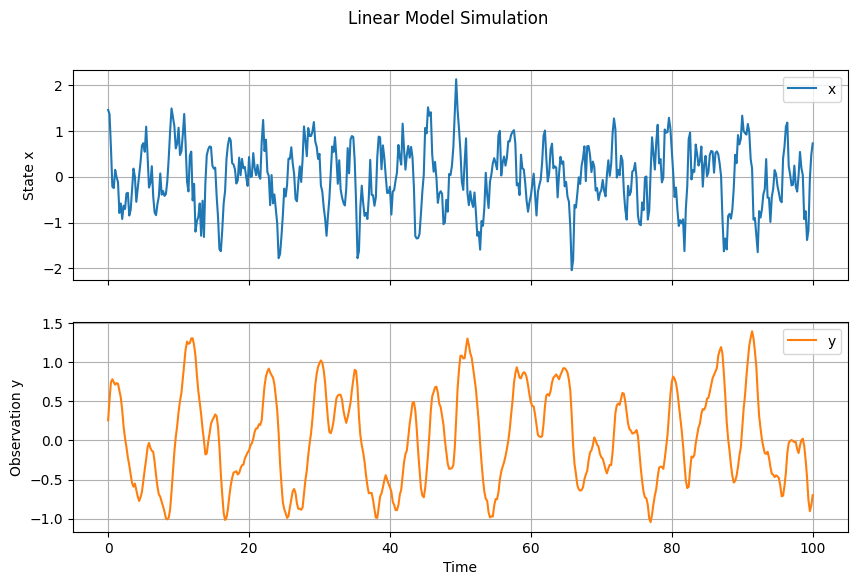

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(time_axis, x_series_np[:, 0], label="x")
axes[0].set_ylabel("State x")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(time_axis, y_series_np[:, 0], label="y", color="tab:orange")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Observation y")
axes[1].legend()
axes[1].grid(True)

fig.suptitle("Linear Model Simulation")
plt.show()